# A notebook for exploring how best to measure the change in Mtb

In [1]:
import napari
from cellpose import models
from macrohet import dataio, tile, visualise, tools
import numpy as np
import os

def view(img):
    return napari.Viewer().add_image(img)

from napari_animation import Animation
from tqdm.auto import tqdm

import btrack
import dask.array as da

from skimage.transform import rescale, resize, downscale_local_mean

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="ticks")
sns.set_palette("Spectral")


### Load all metadata

Both the image metadata and the assay layout metadata

In [2]:
base_dir = '/mnt/DATA/macrohet/'
# base_dir = '/Volumes/lab-gutierrezm/home/users/dayn/macrohet/'
metadata_fn = os.path.join(base_dir, 'macrohet_images/Index.idx.xml')
metadata = dataio.read_harmony_metadata(metadata_fn)  
metadata

Reading metadata XML file...


Extracting HarmonyV5 metadata:   0%|          | 0/113400 [00:00<?, ?it/s]

Extracting metadata complete!


,id,State,URL,Row,Col,FieldID,PlaneID,TimepointID,ChannelID,FlimID,...,PositionZ,AbsPositionZ,MeasurementTimeOffset,AbsTime,MainExcitationWavelength,MainEmissionWavelength,ObjectiveMagnification,ObjectiveNA,ExposureTime,OrientationMatrix
0,0303K1F1P1R1,Ok,r03c03f01p01-ch1sk1fk1fl1.tiff,3,3,1,1,0,1,1,...,0,0.135583505,0,2021-04-16T19:09:33.84+01:00,488,522,40,1.1,0.1,"[[0.990860,0,0,-15.9],[0,-0.990860,0,-44.8],[0..."
1,0303K1F1P1R2,Ok,r03c03f01p01-ch2sk1fk1fl1.tiff,3,3,1,1,0,2,1,...,0,0.135583505,0,2021-04-16T19:09:33.84+01:00,640,706,40,1.1,0.2,"[[0.990860,0,0,-15.9],[0,-0.990860,0,-44.8],[0..."
2,0303K1F1P2R1,Ok,r03c03f01p02-ch1sk1fk1fl1.tiff,3,3,1,2,0,1,1,...,2E-06,0.135585502,0,2021-04-16T19:09:34.12+01:00,488,522,40,1.1,0.1,"[[0.990860,0,0,-15.9],[0,-0.990860,0,-44.8],[0..."
3,0303K1F1P2R2,Ok,r03c03f01p02-ch2sk1fk1fl1.tiff,3,3,1,2,0,2,1,...,2E-06,0.135585502,0,2021-04-16T19:09:34.12+01:00,640,706,40,1.1,0.2,"[[0.990860,0,0,-15.9],[0,-0.990860,0,-44.8],[0..."
4,0303K1F1P3R1,Ok,r03c03f01p03-ch1sk1fk1fl1.tiff,3,3,1,3,0,1,1,...,4E-06,0.135587499,0,2021-04-16T19:09:34.4+01:00,488,522,40,1.1,0.1,"[[0.990860,0,0,-15.9],[0,-0.990860,0,-44.8],[0..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113395,0609K75F9P1R2,Ok,r06c09f09p01-ch2sk75fk1fl1.tiff,6,9,9,1,74,2,1,...,0,0.135533601,266399.61,2021-04-19T21:14:19.477+01:00,640,706,40,1.1,0.2,"[[0.990860,0,0,-15.9],[0,-0.990860,0,-44.8],[0..."
113396,0609K75F9P2R1,Ok,r06c09f09p02-ch1sk75fk1fl1.tiff,6,9,9,2,74,1,1,...,2E-06,0.135535598,266399.61,2021-04-19T21:14:19.757+01:00,488,522,40,1.1,0.1,"[[0.990860,0,0,-15.9],[0,-0.990860,0,-44.8],[0..."
113397,0609K75F9P2R2,Ok,r06c09f09p02-ch2sk75fk1fl1.tiff,6,9,9,2,74,2,1,...,2E-06,0.135535598,266399.61,2021-04-19T21:14:19.757+01:00,640,706,40,1.1,0.2,"[[0.990860,0,0,-15.9],[0,-0.990860,0,-44.8],[0..."
113398,0609K75F9P3R1,Ok,r06c09f09p03-ch1sk75fk1fl1.tiff,6,9,9,3,74,1,1,...,4E-06,0.135537595,266399.61,2021-04-19T21:14:20.037+01:00,488,522,40,1.1,0.1,"[[0.990860,0,0,-15.9],[0,-0.990860,0,-44.8],[0..."


### View assay layout and mask information (optional)

The Opera Phenix acquires many time lapse series from a range of positions. The first step is to inspect the image metadata, presented in the form of an `Assaylayout/experiment_ID.xml` file, to show which positions correspond to which experimental assays.

In [3]:
metadata_path = os.path.join(base_dir, 'macrohet_images/Assaylayout/20210602_Live_cell_IPSDMGFP_ATB.xml')
assay_layout = dataio.read_harmony_metadata(metadata_path, assay_layout=True,)# mask_exist=True,  image_dir = image_dir, image_metadata = metadata)
assay_layout

Reading metadata XML file...
Extracting metadata complete!


Strain Compound Concentration ConcentrationEC
3 4    RD1     CTRL             0             EC0
  5     WT     CTRL             0             EC0
  6     WT      PZA            60            EC50
  7     WT      RIF           0.1            EC50
  8     WT      INH          0.04            EC50
  9     WT      BDQ          0.02            EC50
4 4    RD1     CTRL             0             EC0
  5     WT     CTRL             0             EC0
  6     WT      PZA            60            EC50
  7     WT      RIF           0.1            EC50
  8     WT      INH          0.04            EC50
  9     WT      BDQ          0.02            EC50
5 4    RD1     CTRL             0             EC0
  5     WT     CTRL             0             EC0
  6     WT      PZA           400            EC99
  7     WT      RIF             2            EC99
  8     WT      INH             2            EC99
  9     WT      BDQ           2.5            EC99
6 4    RD1     CTRL             0             EC0
  5     WT     CTRL             0             EC0
  6     WT      PZA           400            EC99
  7     WT      RIF             2            EC99
  8     WT      INH             2            EC99
  9     WT      BDQ           2.5            EC99

# Iteratively load all tracks

and append to a track_dict dictionary

In [4]:
tracks_dict = dict()
### iterate over all experimental conditions
for (row, column), info in tqdm(assay_layout.iterrows(), 
                                desc = 'Progress through positions',
                                total = len(assay_layout)):

    ### load tracks
    with btrack.io.HDF5FileHandler(os.path.join(base_dir, 
                                                f'labels/macrohet_seg_model/{row,column}.h5'), 
                                       'r', 
                                       obj_type='obj_type_1'
                                       ) as reader:
        tracks = reader.tracks
            
    ### append tracks to dictionary
    tracks_dict[(row, column)] = tracks

Progress through positions:   0%|          | 0/24 [00:00<?, ?it/s]

[INFO][2023/06/19 03:38:53 PM] Opening HDF file: /mnt/DATA/macrohet/labels/macrohet_seg_model/(3, 4).h5...
[INFO][2023/06/19 03:38:53 PM] Loading tracks/obj_type_1
[INFO][2023/06/19 03:38:53 PM] Loading LBEP/obj_type_1
[INFO][2023/06/19 03:38:53 PM] Loading objects/obj_type_1 (39878, 5) (39878 filtered: None)
[INFO][2023/06/19 03:38:53 PM] Closing HDF file: /mnt/DATA/macrohet/labels/macrohet_seg_model/(3, 4).h5
[INFO][2023/06/19 03:38:53 PM] Opening HDF file: /mnt/DATA/macrohet/labels/macrohet_seg_model/(3, 5).h5...
[INFO][2023/06/19 03:38:53 PM] Loading tracks/obj_type_1
[INFO][2023/06/19 03:38:53 PM] Loading LBEP/obj_type_1
[INFO][2023/06/19 03:38:53 PM] Loading objects/obj_type_1 (41424, 5) (41424 filtered: None)
[INFO][2023/06/19 03:38:54 PM] Closing HDF file: /mnt/DATA/macrohet/labels/macrohet_seg_model/(3, 5).h5
[INFO][2023/06/19 03:38:54 PM] Opening HDF file: /mnt/DATA/macrohet/labels/macrohet_seg_model/(3, 6).h5...
[INFO][2023/06/19 03:38:54 PM] Loading tracks/obj_type_1
[INFO]

[INFO][2023/06/19 03:39:11 PM] Closing HDF file: /mnt/DATA/macrohet/labels/macrohet_seg_model/(6, 5).h5
[INFO][2023/06/19 03:39:11 PM] Opening HDF file: /mnt/DATA/macrohet/labels/macrohet_seg_model/(6, 6).h5...
[INFO][2023/06/19 03:39:11 PM] Loading tracks/obj_type_1
[INFO][2023/06/19 03:39:11 PM] Loading LBEP/obj_type_1
[INFO][2023/06/19 03:39:11 PM] Loading objects/obj_type_1 (45688, 5) (45688 filtered: None)
[INFO][2023/06/19 03:39:12 PM] Closing HDF file: /mnt/DATA/macrohet/labels/macrohet_seg_model/(6, 6).h5
[INFO][2023/06/19 03:39:12 PM] Opening HDF file: /mnt/DATA/macrohet/labels/macrohet_seg_model/(6, 7).h5...
[INFO][2023/06/19 03:39:12 PM] Loading tracks/obj_type_1
[INFO][2023/06/19 03:39:12 PM] Loading LBEP/obj_type_1
[INFO][2023/06/19 03:39:12 PM] Loading objects/obj_type_1 (45214, 5) (45214 filtered: None)
[INFO][2023/06/19 03:39:14 PM] Closing HDF file: /mnt/DATA/macrohet/labels/macrohet_seg_model/(6, 7).h5
[INFO][2023/06/19 03:39:14 PM] Opening HDF file: /mnt/DATA/macrohe

# Compile all longer length tracks into dataframe

Add extra information such as the MSD of cells between frames

In [164]:
df = pd.read_pickle('/mnt/DATA/macrohet/results/preliminary_sc_measures/sc_dfs/sc_df_>40.pkl')
df

,Time (hours),x,y,x scaled,y scaled,Infection status,Initial infection status,Final infection status,Area,Intracellular mean Mtb content,...,delta Mtb max fold-change normalised max area,delta Mtb/dt,Eccentricity,MSD,Strain,Compound,Concentration,Cell ID,Acquisition ID,Unique ID
0,0,708.125061,77.589088,3568.950308,391.049006,0.0,0.0,1.0,42556.0,365.408905,...,0.095232,0.418707,0.813310,0.000000,RD1,CTRL,EC0,433,"(3, 4)",433.3.4
1,1,725.449097,73.245003,3656.263447,369.154814,0.0,0.0,1.0,48727.0,362.852478,...,0.095232,0.418707,0.896474,17.860383,RD1,CTRL,EC0,433,"(3, 4)",433.3.4
2,2,723.088928,76.431496,3644.368198,385.214738,0.0,0.0,1.0,43484.0,363.515442,...,0.095232,0.418707,0.876911,3.965367,RD1,CTRL,EC0,433,"(3, 4)",433.3.4
3,3,726.009766,79.395073,3659.089219,400.151168,0.0,0.0,1.0,39113.0,360.448578,...,0.095232,0.418707,0.717504,4.161019,RD1,CTRL,EC0,433,"(3, 4)",433.3.4
4,4,728.209656,82.197769,3670.176665,414.276757,0.0,0.0,1.0,32644.0,362.289764,...,0.095232,0.418707,0.425791,3.562951,RD1,CTRL,EC0,433,"(3, 4)",433.3.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
701474,70,757.886719,44.412071,3819.749063,223.836839,1.0,1.0,1.0,71808.0,358.460327,...,-0.000019,-0.092227,0.923363,0.522451,WT,BDQ,EC99,2320,"(6, 9)",2320.6.9
701475,71,760.801514,49.459522,3834.439629,249.275992,1.0,1.0,1.0,65328.0,358.026184,...,-0.000019,-0.092227,0.893735,5.828618,WT,BDQ,EC99,2320,"(6, 9)",2320.6.9
701476,72,761.494873,50.097046,3837.934160,252.489111,1.0,1.0,1.0,66829.0,358.846039,...,-0.000019,-0.092227,0.888738,0.941904,WT,BDQ,EC99,2320,"(6, 9)",2320.6.9
701477,73,759.911255,48.538654,3829.952725,244.634818,1.0,1.0,1.0,71877.0,358.451752,...,-0.000019,-0.092227,0.897926,2.221808,WT,BDQ,EC99,2320,"(6, 9)",2320.6.9


### Renaming delta Mtb method of choice for ease of use

In [165]:
df['dMtb'] = df['delta Mtb max fold-change normalised max area']

### Adding technical replicate label 

In [168]:
assay_layout['Technical replicate'] = assay_layout.groupby(['Strain', 'Compound', 'Concentration', 'ConcentrationEC']).cumcount() + 1


In [171]:
assay_layout

Strain Compound Concentration ConcentrationEC  Technical replicate
3 4    RD1     CTRL             0             EC0                    1
  5     WT     CTRL             0             EC0                    1
  6     WT      PZA            60            EC50                    1
  7     WT      RIF           0.1            EC50                    1
  8     WT      INH          0.04            EC50                    1
  9     WT      BDQ          0.02            EC50                    1
4 4    RD1     CTRL             0             EC0                    2
  5     WT     CTRL             0             EC0                    2
  6     WT      PZA            60            EC50                    2
  7     WT      RIF           0.1            EC50                    2
  8     WT      INH          0.04            EC50                    2
  9     WT      BDQ          0.02            EC50                    2
5 4    RD1     CTRL             0             EC0                    3
  5     WT     CTRL             0             EC0                    3
  6     WT      PZA           400            EC99                    1
  7     WT      RIF             2            EC99                    1
  8     WT      INH             2            EC99                    1
  9     WT      BDQ           2.5            EC99                    1
6 4    RD1     CTRL             0             EC0                    4
  5     WT     CTRL             0             EC0                    4
  6     WT      PZA           400            EC99                    2
  7     WT      RIF             2            EC99                    2
  8     WT      INH             2            EC99                    2
  9     WT      BDQ           2.5            EC99                    2

In [182]:
for index, row_ in tqdm(df.iterrows(), total =len(df)):
    acquisition_id = row_['Acquisition ID']
    repeat_id = assay_layout.loc[acquisition_id]['Technical replicate']
    df.at[index, 'Technical replicate'] = repeat_id

  0%|          | 0/701479 [00:00<?, ?it/s]


KeyboardInterrupt



# Style

In [8]:
sns.set(font='Nimbus Sans', style = 'white')

### Old style

In [9]:
sns.color_palette('PiYG')

[(0.8129181084198386, 0.2544405997693195, 0.5693194925028835),
 (0.9348712033833141, 0.6798154555940021, 0.8312187620146096),
 (0.9856978085351787, 0.9031910803537101, 0.9458669742406767),
 (0.9202614379084968, 0.9629373317954633, 0.8576701268742792),
 (0.6908881199538641, 0.8624375240292197, 0.4883506343713959),
 (0.38269896193771624, 0.6403690888119954, 0.18108419838523643)]

In [10]:
colors = ['#013220',#'#008B8B',#(0.204*0.8, 0.330*0.8, 0.706*0.8), 
          sns.color_palette('PiYG')[0], sns.color_palette('PiYG')[-1]]
colors

['#013220',
 (0.8129181084198386, 0.2544405997693195, 0.5693194925028835),
 (0.38269896193771624, 0.6403690888119954, 0.18108419838523643)]

### New style

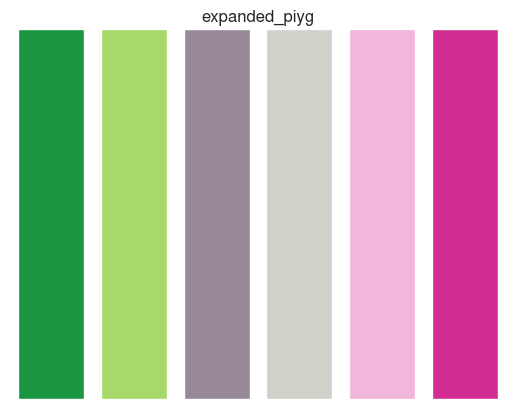

['#1a9641', '#a6d96a', '#978897', '#d1d1ca', '#f1b6da', '#d02c91']


In [11]:
# Get the color palette of the PiYG color map
expanded_piyg = visualise.color_palette('expanded_piyg').colors

sns.set_palette(expanded_piyg)

# Display the colors in the PiYG color map
visualise.show_colors('expanded_piyg')
print(expanded_piyg)


# Output

In [12]:
output_dir = '/mnt/DATA/macrohet/results/preliminary_sc_measures/cumulative_sc_plots/thresholded_480_jun23/'
os.makedirs(output_dir, exist_ok = True)

# How many cells are truly permissive ie deltaMtb>0

#### What do the different distributions of deltaMtb look like?

In [183]:
df_delta_mtb = df.drop_duplicates(subset=['delta Mtb raw', 'delta Mtb max raw','delta Mtb max smooth', 'delta Mtb max fold-change'])
df_delta_mtb

,Time (hours),x,y,x scaled,y scaled,Infection status,Initial infection status,Final infection status,Area,Intracellular mean Mtb content,...,Eccentricity,MSD,Strain,Compound,Concentration,Cell ID,Acquisition ID,Unique ID,dMtb,Technical replicate
0,0,708.125061,77.589088,3568.950308,391.049006,0.0,0.0,1.0,42556.0,365.408905,...,0.813310,0.0,RD1,CTRL,EC0,433,"(3, 4)",433.3.4,0.095232,1.0
42,0,261.683105,4.945100,1318.882852,24.923306,0.0,0.0,0.0,6754.0,355.006958,...,0.913146,0.0,RD1,CTRL,EC0,424,"(3, 4)",424.3.4,-0.000112,1.0
89,0,349.589508,8.074520,1761.931121,40.695581,0.0,0.0,0.0,13672.0,344.202454,...,0.957093,0.0,RD1,CTRL,EC0,425,"(3, 4)",425.3.4,0.000000,1.0
152,0,457.172943,8.791715,2304.151633,44.310242,1.0,1.0,0.0,20542.0,343.157196,...,0.929721,0.0,RD1,CTRL,EC0,426,"(3, 4)",426.3.4,0.000586,1.0
226,0,663.630920,10.924337,3344.699839,55.058660,0.0,0.0,0.0,20098.0,353.067780,...,0.805467,0.0,RD1,CTRL,EC0,427,"(3, 4)",427.3.4,0.000544,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
701271,33,660.136597,577.060730,3327.088447,2908.386079,0.0,0.0,0.0,47448.0,377.264587,...,0.952213,0.0,WT,BDQ,EC99,2297,"(6, 9)",2297.6.9,0.000032,NaN
701313,33,224.372467,131.369995,1130.837234,662.104775,1.0,1.0,1.0,98867.0,373.245178,...,0.885194,0.0,WT,BDQ,EC99,2292,"(6, 9)",2292.6.9,-0.000153,NaN
701355,33,1106.007935,1032.619019,5574.279990,5204.399854,0.0,0.0,1.0,53641.0,366.914032,...,0.950100,0.0,WT,BDQ,EC99,2286,"(6, 9)",2286.6.9,0.000089,NaN
701397,34,477.689026,538.676697,2407.552690,2714.930552,0.0,0.0,0.0,36503.0,356.196930,...,0.796381,0.0,WT,BDQ,EC99,2324,"(6, 9)",2324.6.9,0.000167,NaN


In [187]:
for index, row_ in tqdm(df_delta_mtb.iterrows(), total =len(df_delta_mtb)):
    acquisition_id = row_['Acquisition ID']
    repeat_id = assay_layout.loc[acquisition_id]['Technical replicate']
    df_delta_mtb.at[index, 'Technical replicate'] = repeat_id

  0%|          | 0/10028 [00:00<?, ?it/s]

In [188]:
df_delta_mtb

,Time (hours),x,y,x scaled,y scaled,Infection status,Initial infection status,Final infection status,Area,Intracellular mean Mtb content,...,Eccentricity,MSD,Strain,Compound,Concentration,Cell ID,Acquisition ID,Unique ID,dMtb,Technical replicate
0,0,708.125061,77.589088,3568.950308,391.049006,0.0,0.0,1.0,42556.0,365.408905,...,0.813310,0.0,RD1,CTRL,EC0,433,"(3, 4)",433.3.4,0.095232,1.0
42,0,261.683105,4.945100,1318.882852,24.923306,0.0,0.0,0.0,6754.0,355.006958,...,0.913146,0.0,RD1,CTRL,EC0,424,"(3, 4)",424.3.4,-0.000112,1.0
89,0,349.589508,8.074520,1761.931121,40.695581,0.0,0.0,0.0,13672.0,344.202454,...,0.957093,0.0,RD1,CTRL,EC0,425,"(3, 4)",425.3.4,0.000000,1.0
152,0,457.172943,8.791715,2304.151633,44.310242,1.0,1.0,0.0,20542.0,343.157196,...,0.929721,0.0,RD1,CTRL,EC0,426,"(3, 4)",426.3.4,0.000586,1.0
226,0,663.630920,10.924337,3344.699839,55.058660,0.0,0.0,0.0,20098.0,353.067780,...,0.805467,0.0,RD1,CTRL,EC0,427,"(3, 4)",427.3.4,0.000544,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
701271,33,660.136597,577.060730,3327.088447,2908.386079,0.0,0.0,0.0,47448.0,377.264587,...,0.952213,0.0,WT,BDQ,EC99,2297,"(6, 9)",2297.6.9,0.000032,2.0
701313,33,224.372467,131.369995,1130.837234,662.104775,1.0,1.0,1.0,98867.0,373.245178,...,0.885194,0.0,WT,BDQ,EC99,2292,"(6, 9)",2292.6.9,-0.000153,2.0
701355,33,1106.007935,1032.619019,5574.279990,5204.399854,0.0,0.0,1.0,53641.0,366.914032,...,0.950100,0.0,WT,BDQ,EC99,2286,"(6, 9)",2286.6.9,0.000089,2.0
701397,34,477.689026,538.676697,2407.552690,2714.930552,0.0,0.0,0.0,36503.0,356.196930,...,0.796381,0.0,WT,BDQ,EC99,2324,"(6, 9)",2324.6.9,0.000167,2.0


In [189]:
from bokeh.models import HoverTool
from bokeh.plotting import figure, show, output_file, ColumnDataSource, output_notebook
from bokeh.transform import factor_cmap
from bokeh.palettes import Spectral6
from bokeh.models import WheelZoomTool
from bokeh.plotting import save
from bokeh.models import Label
from bokeh.models import LogScale
from bokeh.models import NumeralTickFormatter
from bokeh.models import HoverTool
from bokeh.layouts import column
from bokeh.layouts import gridplot
from scipy.stats import gaussian_kde
from bokeh.models import Range1d

output_notebook()


Loading BokehJS ...

In [16]:
expanded_piyg_dict = {
                      'CTRL':expanded_piyg[0], 
                      'RD1':expanded_piyg[-1],
                      'BDQ':expanded_piyg[0], 
                      'INH':expanded_piyg[1], 
                      'PZA':expanded_piyg[4], 
                      'RIF':expanded_piyg[5]}

# KDE hist

In [89]:
output_notebook()

Loading BokehJS ...

In [102]:
assay_layout

Strain Compound Concentration ConcentrationEC
3 4    RD1     CTRL             0             EC0
  5     WT     CTRL             0             EC0
  6     WT      PZA            60            EC50
  7     WT      RIF           0.1            EC50
  8     WT      INH          0.04            EC50
  9     WT      BDQ          0.02            EC50
4 4    RD1     CTRL             0             EC0
  5     WT     CTRL             0             EC0
  6     WT      PZA            60            EC50
  7     WT      RIF           0.1            EC50
  8     WT      INH          0.04            EC50
  9     WT      BDQ          0.02            EC50
5 4    RD1     CTRL             0             EC0
  5     WT     CTRL             0             EC0
  6     WT      PZA           400            EC99
  7     WT      RIF             2            EC99
  8     WT      INH             2            EC99
  9     WT      BDQ           2.5            EC99
6 4    RD1     CTRL             0             EC0
  5     WT     CTRL             0             EC0
  6     WT      PZA           400            EC99
  7     WT      RIF             2            EC99
  8     WT      INH             2            EC99
  9     WT      BDQ           2.5            EC99

In [197]:
outlier_df[outlier_df['Unique ID'] == '106.3.5']['glimpse_url_tn'].iloc[0]

'https://macrohet.s3.eu-west-2.amazonaws.com/dMtb/dMtb_glimpses/glimpse_106.3.5_t-1.png'

In [202]:
from bokeh.layouts import gridplot
from scipy.stats import gaussian_kde

# Create the hover tool
hover = HoverTool(
    tooltips=
    """ <div>
        <div style="position: relative; display: inline-block;">
            <img
                src="@glimpse_url_t0" height="120" alt="@glimpse_url_t0" width="120"
                style="float: left; margin: 0px 15px 15px 0px;"
                border="2"
            >
            <div style="position: absolute; bottom: 5px; right: 5px; background-color: lightgrey; padding: 5px;">
                <span style="font-size: 12px; color: black;">t = 0</span>
            </div>
            </img>
        </div>
        <div style="position: relative; display: inline-block;">
            <img
                src="@glimpse_url_tn" height="120" alt="@glimpse_url_tn" width="120"
                style="float: left; margin: 0px 15px 15px 0px;"
                border="2"
            >
            <div style="position: absolute; bottom: 5px; right: 5px; background-color: lightgrey; padding: 5px;">
                <span style="font-size: 12px; color: black;">t = final</span>
            </div>
            </img>
        </div>
        <div>
             <span style="font-size: 17px; font-weight: bold; color: black;">Cell ID: @cell_ID</span>
         </div>
         <div>
             <span style="font-size: 15px; color: black;">ΔMtb: @x</span>
         </div>
         <div>
             <span style="font-size: 15px; color: black;">Strain: @strain</span>
         </div>
         <div>
             <span style="font-size: 15px; color: black;">Compound: @compound</span>
         </div>
         <div>
             <span style="font-size: 15px; color: black;">Concentration: @concentration</span>
         </div>
         <div>
             <span style="font-size: 15px; color: black;">Tech. replicate: @tech_rep</span>
         </div>
    </div>
""")

# Create the upper plot
p1 = figure(height=400, 
            width=500, 
            title='Histograms showing the distribution of \nintracellular Mtb growth (ΔMtb)\nunder different drug conditions', 
            y_axis_label='Frequency',
            tools='crosshair,save,pan,box_zoom,reset,wheel_zoom')
p1.toolbar.active_scroll = p1.select_one(WheelZoomTool)
p1.x_range = Range1d(-0.4, 0.4)
# Customize y-axis ticker
p1.xaxis.visible = False  # Remove x-axis

# Create the lower plot
p2 = figure(height=200, 
            width=500, 
#             x_axis_label='ΔMtb \n(fold-change relative to Macrophage area)',
            y_axis_label='Data browser\nshowing outliers\n>1 S.D. from mean',
            tools='crosshair,save,pan,box_zoom,reset,wheel_zoom', 
#             title='Data browser showing only \noutliers >1 S.D. from mean',
            x_range=p1.x_range)
p2.y_range = Range1d(5, 10)
p2.yaxis.ticker = []  # Remove y-axis ticks
p2.yaxis.formatter = NumeralTickFormatter(format="0")  # Format tick labels

p2.toolbar.active_scroll = p2.select_one(WheelZoomTool)

p2.add_tools(hover)  # Add the instance of HoverTool

outliers = list()
for index, condition in df_delta_mtb.groupby(['Strain', 'Compound', 'Concentration']).size().reset_index().rename(columns={0: 'count'}).iterrows():
    # only ec50
    if condition['Concentration'] != 'EC50':
        continue
    strain = condition['Strain']
    compound = condition['Compound']
    concentration = condition['Concentration']
    label = f'{strain}, {compound}, {concentration}'
    subset_df = df_delta_mtb[(df_delta_mtb['Strain'] == strain)
                             & (df_delta_mtb['Compound'] == compound)
                             & (df_delta_mtb['Concentration'] == concentration)
#                              & (df_delta_mtb['Technical replicate'] == 1)
                            ]
    data = subset_df['dMtb'].dropna()  # Remove NA values, if any
    kde = gaussian_kde(data)
    x = np.linspace(data.min(), data.max(), 100)
    kde_values = kde(x)

    source = ColumnDataSource(data=dict(x=x, kde_values=kde_values))

    # Create a quad glyph for the histogram in the upper plot
    p1.varea(x='x', y1=0, y2='kde_values',
             source=source, 
             fill_color=expanded_piyg_dict[compound], 
             alpha=0.6,
             muted_color=expanded_piyg_dict[compound], 
             muted_alpha=0.1,
             legend_label=label)
    p1.line(x='x', y='kde_values',
             source=source, 
             line_color=expanded_piyg_dict[compound], 
             line_width = 3, 
             alpha=1,
             muted_color=expanded_piyg_dict[compound], 
             muted_alpha=0.1,
             legend_label=label)
    
    # create a separate outlier df for below plot
    # Calculate the mean and standard deviation of dMtb
    mean = subset_df['dMtb'].mean()
    std = subset_df['dMtb'].std()

    # Define a threshold to determine outliers (e.g., 2 standard deviations from the mean)
    threshold = 1 * std

    # Filter out the non outliers from subset_df
    outlier_df = subset_df[abs(subset_df['dMtb'] - mean) >= threshold]
    outliers.append(outlier_df)
    
    # append url to df 
    for index, row_ in outlier_df.iterrows():
        unique_ID = row_['Unique ID']
        cell_ID, row, column = unique_ID.split('.') 
        t0 = row_['Time (hours)']
        outlier_df.at[index, 'glimpse_url_t0'] = f'https://macrohet.s3.eu-west-2.amazonaws.com/dMtb/dMtb_glimpses/glimpse_{cell_ID}.{row}.{column}_t{t0}.png'
        outlier_df.at[index, 'glimpse_url_tn'] = f'https://macrohet.s3.eu-west-2.amazonaws.com/dMtb/dMtb_glimpses/glimpse_{cell_ID}.{row}.{column}_t{-1}.png'

    # Create scatter plots for the lower plot
    source = ColumnDataSource(
            name=label,
            data=dict(
            x=outlier_df['dMtb'],
            y=outlier_df['Acquisition ID'].apply(lambda x: x[1]),
#             y=outlier_df.index/5E5,
            glimpse_url_t0=outlier_df['glimpse_url_t0'],
            glimpse_url_tn=outlier_df['glimpse_url_tn'], 
            dMtb=outlier_df['dMtb'], 
            cell_ID=outlier_df['Cell ID'], 
            strain=outlier_df['Strain'],
            compound=outlier_df['Compound'],
            concentration=outlier_df['Concentration'],
            tech_rep=outlier_df['Technical replicate']
        ))
    p2.scatter('x', 'y', 
               source=source,
               color=expanded_piyg_dict[compound], 
               alpha=0.9, 
               size=20,
               line_color='black',  # Set the color of the outline
               line_width=1,  # Set the width of the outline
               muted_color=expanded_piyg_dict[compound], 
               muted_alpha=0.1,
#                legend_label=label
              )

# Set the legend location for the upper plot
p1.legend.location = "top_left"

# Uncomment the following line to set the legend location for the lower plot
# p2.legend.location = "top_left"

# Set the click_policy to "mute" for the legend in the upper plot
p1.legend.click_policy = "mute"
# Uncomment the following line to set the click_policy to "mute" for the legend in the lower plot
# p2.legend.click_policy = "mute"
N = len(df_delta_mtb['Unique ID'].unique())
# Create the upper plot
p3 = figure(height=400, 
            width=500, 
            title=f'N = {N} individual macrophages tracked \nand measured for intracellular Mtb growth', 
#             y_axis_label='Frequency',
            tools='crosshair,save,pan,box_zoom,reset,wheel_zoom')
p3.toolbar.active_scroll = p3.select_one(WheelZoomTool)
p3.x_range = Range1d(-0.4, 0.4)

# Customize y-axis ticker
p3.xaxis.visible = False  # Remove x-axis

# Create the lower plot
p4 = figure(height=200, 
            width=500, 
            x_axis_label='ΔMtb (fold-change relative to Macrophage area)',
#             y_axis_label='Outlier browser \n(1 S.D. from mean)',
            tools='crosshair,save,pan,box_zoom,reset,wheel_zoom', 
            x_range=p3.x_range)
p4.y_range = Range1d(5,10)
p4.yaxis.ticker = []  # Remove y-axis ticks
p4.yaxis.formatter = NumeralTickFormatter(format="0")  # Format tick labels

p4.toolbar.active_scroll = p4.select_one(WheelZoomTool)

p4.add_tools(hover)  # Add the instance of HoverTool (no need to repeat)


for index, condition in df_delta_mtb.groupby(['Strain', 'Compound', 'Concentration']).size().reset_index().rename(columns={0: 'count'}).iterrows():
    # only ec99
    if condition['Concentration'] != 'EC99':
        continue
    strain = condition['Strain']
    compound = condition['Compound']
    concentration = condition['Concentration']
    label = f'{strain}, {compound}, {concentration}'
    subset_df = df_delta_mtb[(df_delta_mtb['Strain'] == strain)
                             & (df_delta_mtb['Compound'] == compound)
                             & (df_delta_mtb['Concentration'] == concentration)
#                              & (df_delta_mtb['Technical replicate'] == 1)
                            ]
    data = subset_df['dMtb'].dropna()  # Remove NA values, if any
    kde = gaussian_kde(data)
    x = np.linspace(data.min(), data.max(), 100)
    kde_values = kde(x)

    source = ColumnDataSource(data=dict(x=x, kde_values=kde_values))

    # Create a quad glyph for the histogram in the upper plot
    p3.varea(x='x', y1=0, y2='kde_values',
             source=source, 
             fill_color=expanded_piyg_dict[compound], 
             alpha=0.6,
             muted_color=expanded_piyg_dict[compound], 
             muted_alpha=0.1,
             legend_label=label)
    p3.line(x='x', y='kde_values',
             source=source, 
             line_color=expanded_piyg_dict[compound], 
             line_width = 3,
             alpha=1,
             muted_color=expanded_piyg_dict[compound], 
             muted_alpha=0.1,
             legend_label=label)
    
    
    # create a separate outlier df for below plot
    # Calculate the mean and standard deviation of dMtb
    mean = subset_df['dMtb'].mean()
    std = subset_df['dMtb'].std()

    # Define a threshold to determine outliers (e.g., 2 standard deviations from the mean)
    threshold = 1 * std

    # Filter out the non outliers from subset_df
    outlier_df = subset_df[abs(subset_df['dMtb'] - mean) >= threshold]
    outliers.append(outlier_df)
    
    # append url to df 
    for index, row_ in outlier_df.iterrows():
        unique_ID = row_['Unique ID']
        cell_ID, row, column = unique_ID.split('.') 
        t0 = row_['Time (hours)']
        outlier_df.at[index, 'glimpse_url_t0'] = f'https://macrohet.s3.eu-west-2.amazonaws.com/dMtb/dMtb_glimpses/glimpse_{cell_ID}.{row}.{column}_t{t0}.png'
        outlier_df.at[index, 'glimpse_url_tn'] = f'https://macrohet.s3.eu-west-2.amazonaws.com/dMtb/dMtb_glimpses/glimpse_{cell_ID}.{row}.{column}_t{-1}.png'

    # Create scatter plots for the lower plot
    source = ColumnDataSource(
            name=label,
            data=dict(
            x=outlier_df['dMtb'],
            y=outlier_df['Acquisition ID'].apply(lambda x: x[1]),
#             y=outlier_df.index/5E5,            
            glimpse_url_t0=outlier_df['glimpse_url_t0'],
            glimpse_url_tn=outlier_df['glimpse_url_tn'], 
            dMtb=outlier_df['dMtb'], 
            cell_ID=outlier_df['Cell ID'], 
            strain=outlier_df['Strain'],
            compound=outlier_df['Compound'],
            concentration=outlier_df['Concentration'],
            tech_rep=outlier_df['Technical replicate']
        ))
    p4.scatter('x', 'y', 
               source=source,
               color=expanded_piyg_dict[compound], 
               alpha=0.9, 
               size=20,
               line_color='black',  # Set the color of the outline
               line_width=1,  # Set the width of the outline
               muted_color=expanded_piyg_dict[compound], 
               muted_alpha=0.1,
#                legend_label=label
              )

# Set the legend location for the upper plot
p3.legend.location = "top_left"

# Uncomment the following line to set the legend location for the lower plot
# p2.legend.location = "top_left"

# Set the click_policy to "mute" for the legend in the upper plot
p3.legend.click_policy = "mute"
# Uncomment the following line to set the click_policy to "mute" for the legend in the lower plot
# p2.legend.click_policy = "mute"

# Create the upper plot
p5 = figure(height=400, 
            width=500, 
            title='Control experiments', 
#             y_axis_label='Frequency',
            tools='crosshair,save,pan,box_zoom,reset,wheel_zoom')
p5.toolbar.active_scroll = p5.select_one(WheelZoomTool)
p5.x_range = Range1d(-0.4, 0.4)


# Customize y-axis ticker
p5.xaxis.visible = False  # Remove x-axis

# Create the lower plot
p6 = figure(height=200, 
            width=500, 
#             x_axis_label='ΔMtb \n(fold-change relative to Macrophage area)',
#             y_axis_label='technical replicate number',
            tools='crosshair,save,pan,box_zoom,reset,wheel_zoom', 
#             title='Outlier browser \n(1 S.D. from mean)',
            x_range=p5.x_range)
p6.y_range = Range1d(3, 6)
p6.yaxis.ticker = []  # Remove y-axis ticks
p6.yaxis.formatter = NumeralTickFormatter(format="0")  # Format tick labels

p6.toolbar.active_scroll = p6.select_one(WheelZoomTool)

p6.add_tools(hover)  # Add the instance of HoverTool (no need to repeat)

for index, condition in df_delta_mtb.groupby(['Strain', 'Compound', 'Concentration']).size().reset_index().rename(columns={0: 'count'}).iterrows():
    # only ec0
    if condition['Concentration'] != 'EC0':
        continue
    strain = condition['Strain']
    compound = condition['Compound']
    concentration = condition['Concentration']
    label = f'{strain}, {compound}, {concentration}'
    subset_df = df_delta_mtb[(df_delta_mtb['Strain'] == strain)
                             & (df_delta_mtb['Compound'] == compound)
                             & (df_delta_mtb['Concentration'] == concentration)
#                              & (df_delta_mtb['Technical replicate'] == 1)
                            ]
    data = subset_df['dMtb'].dropna()  # Remove NA values, if any
    kde = gaussian_kde(data)
    x = np.linspace(data.min(), data.max(), 100)
    kde_values = kde(x)

    source = ColumnDataSource(data=dict(x=x, kde_values=kde_values))

    # Create a quad glyph for the histogram in the upper plot
    p5.varea(x='x', y1=0, y2='kde_values',
             source=source, 
             fill_color = expanded_piyg[0] if strain == 'WT' else expanded_piyg[-1],
             alpha=0.6,
             muted_color=expanded_piyg_dict[compound], 
             muted_alpha=0.1,
             legend_label=label)
    p5.line(x='x', y='kde_values',
             source=source, 
             line_color = expanded_piyg[0] if strain == 'WT' else expanded_piyg[-1], 
             line_width = 1,
             line_dash = 'dashed',
             alpha=1,
             muted_color=expanded_piyg_dict[compound], 
             muted_alpha=0.1,
             legend_label=label)
    
    # create a separate outlier df for below plot
    # Calculate the mean and standard deviation of dMtb
    mean = subset_df['dMtb'].mean()
    std = subset_df['dMtb'].std()

    # Define a threshold to determine outliers (e.g., 2 standard deviations from the mean)
    threshold = 1 * std

    # Filter out the non outliers from subset_df
    outlier_df = subset_df[abs(subset_df['dMtb'] - mean) >= threshold]
    outliers.append(outlier_df)
    
    # append url to df 
    for index, row_ in outlier_df.iterrows():
        unique_ID = row_['Unique ID']
        cell_ID, row, column = unique_ID.split('.') 
        t0 = row_['Time (hours)']
        outlier_df.at[index, 'glimpse_url_t0'] = f'https://macrohet.s3.eu-west-2.amazonaws.com/dMtb/dMtb_glimpses/glimpse_{cell_ID}.{row}.{column}_t{t0}.png'
        outlier_df.at[index, 'glimpse_url_tn'] = f'https://macrohet.s3.eu-west-2.amazonaws.com/dMtb/dMtb_glimpses/glimpse_{cell_ID}.{row}.{column}_t{-1}.png'

    # Create scatter plots for the lower plot
    source = ColumnDataSource(
            name=label,
            data=dict(
            x=outlier_df['dMtb'],
            y=outlier_df['Acquisition ID'].apply(lambda x: x[1]),
#             y=outlier_df.index/5E5,            
            glimpse_url_t0=outlier_df['glimpse_url_t0'],
            glimpse_url_tn=outlier_df['glimpse_url_tn'], 
            dMtb=outlier_df['dMtb'], 
            cell_ID=outlier_df['Cell ID'], 
            strain=outlier_df['Strain'],
            compound=outlier_df['Compound'],
            concentration=outlier_df['Concentration'],
            tech_rep=outlier_df['Technical replicate']
        ))
    p6.scatter('x', 'y', 
               source=source,
               fill_color = expanded_piyg[0] if strain == 'WT' else expanded_piyg[-1],
               alpha=0.9, 
               size=20,
               line_color='black',  # Set the color of the outline
               line_width=1,  # Set the width of the outline
               muted_color=expanded_piyg_dict[compound], 
               muted_alpha=0.1,
#                legend_label=label
              )

# Set the legend location for the upper plot
p5.legend.location = "top_left"

# Uncomment the following line to set the legend location for the lower plot
# p2.legend.location = "top_left"

# Set the click_policy to "mute" for the legend in the upper plot
p5.legend.click_policy = "mute"
# Uncomment the following line to set the click_policy to "mute" for the legend in the lower plot
# p2.legend.click_policy = "mute"

# Create a grid plot with both plots repeated on the right-hand side
p = gridplot([[p1, p3, p5], [p2, p4, p6]])

output_file("dMtb_kde.html",title="dMtb")

show(p)


In [126]:
outlier_df

,Time (hours),x,y,x scaled,y scaled,Infection status,Initial infection status,Final infection status,Area,Intracellular mean Mtb content,...,Strain,Compound,Concentration,Cell ID,Acquisition ID,Unique ID,dMtb,Technical replicate,glimpse_url_t0,glimpse_url_tn
30454,0,847.173218,355.198486,4269.753018,1790.200371,0.0,0.0,1.0,49481.0,358.327667,...,WT,CTRL,EC0,360,"(3, 5)",360.3.5,0.263661,1,https://macrohet.s3.eu-west-2.amazonaws.com/dM...,https://macrohet.s3.eu-west-2.amazonaws.com/dM...
30603,0,992.732239,347.671783,5003.370483,1752.265789,0.0,0.0,1.0,13415.0,386.294830,...,WT,CTRL,EC0,362,"(3, 5)",362.3.5,1.112205,1,https://macrohet.s3.eu-west-2.amazonaws.com/dM...,https://macrohet.s3.eu-west-2.amazonaws.com/dM...
34092,0,1013.018066,613.704102,5105.611055,3093.068672,0.0,0.0,1.0,33571.0,390.042694,...,WT,CTRL,EC0,484,"(3, 5)",484.3.5,2.288280,1,https://macrohet.s3.eu-west-2.amazonaws.com/dM...,https://macrohet.s3.eu-west-2.amazonaws.com/dM...
34228,0,25.068916,609.675537,126.347338,3072.764707,1.0,1.0,1.0,21285.0,342.777039,...,WT,CTRL,EC0,486,"(3, 5)",486.3.5,0.279296,1,https://macrohet.s3.eu-west-2.amazonaws.com/dM...,https://macrohet.s3.eu-west-2.amazonaws.com/dM...
34737,0,907.020264,626.401550,4571.382129,3157.063813,0.0,0.0,1.0,14859.0,380.547668,...,WT,CTRL,EC0,539,"(3, 5)",539.3.5,2.209745,1,https://macrohet.s3.eu-west-2.amazonaws.com/dM...,https://macrohet.s3.eu-west-2.amazonaws.com/dM...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
575693,4,757.554932,170.470444,3818.076855,859.171036,1.0,1.0,1.0,13940.0,388.782074,...,WT,CTRL,EC0,1075,"(6, 5)",1075.6.5,0.276201,2,https://macrohet.s3.eu-west-2.amazonaws.com/dM...,https://macrohet.s3.eu-west-2.amazonaws.com/dM...
577155,6,122.582176,206.176346,617.814168,1039.128783,0.0,0.0,1.0,14622.0,382.337433,...,WT,CTRL,EC0,1216,"(6, 5)",1216.6.5,0.258478,2,https://macrohet.s3.eu-west-2.amazonaws.com/dM...,https://macrohet.s3.eu-west-2.amazonaws.com/dM...
577358,7,818.922974,438.001740,4127.371787,2207.528767,0.0,0.0,1.0,31789.0,345.671936,...,WT,CTRL,EC0,1314,"(6, 5)",1314.6.5,1.900590,2,https://macrohet.s3.eu-west-2.amazonaws.com/dM...,https://macrohet.s3.eu-west-2.amazonaws.com/dM...
581095,16,333.640533,118.059662,1681.548289,595.020696,0.0,0.0,1.0,52010.0,366.959137,...,WT,CTRL,EC0,1894,"(6, 5)",1894.6.5,1.283940,2,https://macrohet.s3.eu-west-2.amazonaws.com/dM...,https://macrohet.s3.eu-west-2.amazonaws.com/dM...


# Adding images


In [94]:
outliers[outliers['Unique ID'] == '1043.6.7']

,Time (hours),x,y,x scaled,y scaled,Infection status,Initial infection status,Final infection status,Area,Intracellular mean Mtb content,...,Strain,Compound,Concentration,Cell ID,Acquisition ID,Unique ID,dMtb,Technical replicate,glimpse_url_t0,glimpse_url_tn
189,4,1031.20813,519.976868,5197.288975,2620.683413,0.0,0.0,1.0,7396.0,388.9328,...,WT,RIF,EC99,1043,"(6, 7)",1043.6.7,0.127882,2,https://macrohet.s3.eu-west-2.amazonaws.com/dM...,https://macrohet.s3.eu-west-2.amazonaws.com/dM...


In [91]:
assay_layout

Strain Compound Concentration ConcentrationEC
3 4    RD1     CTRL             0             EC0
  5     WT     CTRL             0             EC0
  6     WT      PZA            60            EC50
  7     WT      RIF           0.1            EC50
  8     WT      INH          0.04            EC50
  9     WT      BDQ          0.02            EC50
4 4    RD1     CTRL             0             EC0
  5     WT     CTRL             0             EC0
  6     WT      PZA            60            EC50
  7     WT      RIF           0.1            EC50
  8     WT      INH          0.04            EC50
  9     WT      BDQ          0.02            EC50
5 4    RD1     CTRL             0             EC0
  5     WT     CTRL             0             EC0
  6     WT      PZA           400            EC99
  7     WT      RIF             2            EC99
  8     WT      INH             2            EC99
  9     WT      BDQ           2.5            EC99
6 4    RD1     CTRL             0             EC0
  5     WT     CTRL             0             EC0
  6     WT      PZA           400            EC99
  7     WT      RIF             2            EC99
  8     WT      INH             2            EC99
  9     WT      BDQ           2.5            EC99

In [86]:
['dMtb']

189    0.127882
Name: dMtb, dtype: float64

In [93]:
outliers = pd.concat(outliers, ignore_index=True)
outliers

,Time (hours),x,y,x scaled,y scaled,Infection status,Initial infection status,Final infection status,Area,Intracellular mean Mtb content,...,Strain,Compound,Concentration,Cell ID,Acquisition ID,Unique ID,dMtb,Technical replicate,glimpse_url_t0,glimpse_url_tn
0,0,539.885864,99.211456,2721.024756,500.025740,0.0,0.0,1.0,24629.0,367.672302,...,WT,BDQ,EC50,421,"(3, 9)",421.3.9,0.244142,1,https://macrohet.s3.eu-west-2.amazonaws.com/dM...,https://macrohet.s3.eu-west-2.amazonaws.com/dM...
1,0,1074.527832,811.853455,5415.620273,4091.741411,0.0,0.0,1.0,19622.0,369.415039,...,WT,BDQ,EC50,113,"(3, 9)",113.3.9,1.114547,1,https://macrohet.s3.eu-west-2.amazonaws.com/dM...,https://macrohet.s3.eu-west-2.amazonaws.com/dM...
2,0,1097.321167,847.022522,5530.498682,4268.993511,0.0,0.0,1.0,10637.0,375.349060,...,WT,BDQ,EC50,26,"(3, 9)",26.3.9,0.254726,1,https://macrohet.s3.eu-west-2.amazonaws.com/dM...,https://macrohet.s3.eu-west-2.amazonaws.com/dM...
3,0,1039.033447,916.104431,5236.728574,4617.166333,1.0,1.0,1.0,19872.0,389.052826,...,WT,BDQ,EC50,63,"(3, 9)",63.3.9,0.154472,1,https://macrohet.s3.eu-west-2.amazonaws.com/dM...,https://macrohet.s3.eu-west-2.amazonaws.com/dM...
4,0,771.073486,1052.282593,3886.210371,5303.504268,0.0,0.0,1.0,28811.0,361.714722,...,WT,BDQ,EC50,275,"(3, 9)",275.3.9,0.160494,1,https://macrohet.s3.eu-west-2.amazonaws.com/dM...,https://macrohet.s3.eu-west-2.amazonaws.com/dM...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
310,4,757.554932,170.470444,3818.076855,859.171036,1.0,1.0,1.0,13940.0,388.782074,...,WT,CTRL,EC0,1075,"(6, 5)",1075.6.5,0.276201,2,https://macrohet.s3.eu-west-2.amazonaws.com/dM...,https://macrohet.s3.eu-west-2.amazonaws.com/dM...
311,6,122.582176,206.176346,617.814168,1039.128783,0.0,0.0,1.0,14622.0,382.337433,...,WT,CTRL,EC0,1216,"(6, 5)",1216.6.5,0.258478,2,https://macrohet.s3.eu-west-2.amazonaws.com/dM...,https://macrohet.s3.eu-west-2.amazonaws.com/dM...
312,7,818.922974,438.001740,4127.371787,2207.528767,0.0,0.0,1.0,31789.0,345.671936,...,WT,CTRL,EC0,1314,"(6, 5)",1314.6.5,1.900590,2,https://macrohet.s3.eu-west-2.amazonaws.com/dM...,https://macrohet.s3.eu-west-2.amazonaws.com/dM...
313,16,333.640533,118.059662,1681.548289,595.020696,0.0,0.0,1.0,52010.0,366.959137,...,WT,CTRL,EC0,1894,"(6, 5)",1894.6.5,1.283940,2,https://macrohet.s3.eu-west-2.amazonaws.com/dM...,https://macrohet.s3.eu-west-2.amazonaws.com/dM...


In [35]:
for index, row_ in tqdm(outliers.iterrows(), total = len(outliers)):
    unique_ID = row_['Unique ID']
    cell_ID, row, column = unique_ID.split('.') 
    t0 = row_['Time (hours)']
    time = [t0, -1]
    for t in time:
        output_fn = f'/mnt/DATA/macrohet/results/glimpses/interactive_plots/dMtb/glimpse_{cell_ID}.{row}.{column}_t{t}.png'
        if os.path.exists(output_fn):
            continue
        glimpse = tn_glimpse_maker(unique_ID, df, time=t)
        imsave(output_fn, glimpse)

  0%|          | 0/315 [00:00<?, ?it/s]

In [24]:
from macrohet import visualise, aws_tools

In [74]:
from macrohet import aws_tools

In [595]:
import os
import numpy as np
import cv2
import btrack
from macrohet import tile, dataio
from skimage.io import imsave

def tn_glimpse_maker(unique_ID, df, time, crop_size=None, track_scale_factor=5.04, mask_outline = True):
    # extract row and column from unique_ID
    cell_ID, row, column = unique_ID.split('.') 
    # pre-load images
    base_dir = '/mnt/DATA/macrohet/'
    image_dir = os.path.join(base_dir, 'macrohet_images/Images')
    images = tile.compile_mosaic(image_dir, 
                                 metadata, 
                                 row, column, 
                                 set_plane='sum_proj',
                                 )
    ### load tracks
    with btrack.io.HDF5FileHandler(os.path.join(base_dir, 
                                                f'labels/macrohet_seg_model/{int(row),int(column)}.h5'), 
                                       'r', 
                                       obj_type='obj_type_1'
                                       ) as reader:
        segmentation = reader.segmentation

    # extract single cell df
    sc_df = df[df['Unique ID']==unique_ID]

    if isinstance(time, int):
        time_values = [time]
    elif isinstance(time, (list, tuple)):
        time_values = time
    elif isinstance(time, range):
        time_values = list(time)
    else:
        raise ValueError("Invalid input type for 'time'. Please provide an integer, a list of integers, or a range.")

    for t in time_values:
        if t == -1:
            t = sc_df['Time (hours)'].iloc[-1]
        
        sc_df_t = sc_df[sc_df['Time (hours)'] == t]

        # Extract xy coordinates and transpose for python and area from the cell information
        y_coord, x_coord, area, t = sc_df_t.loc[:,['x', 'y', 'Area', 'Time (hours)']].values[0]

        # Scale according to tracking shrinkage
        y_coord, x_coord = y_coord * track_scale_factor, x_coord * track_scale_factor

        if not crop_size:
            # Calculate the side length for cropping based on the square root of the area
            side_length = int(np.sqrt(area)) * 2

        # Calculate the cropping boundaries
        x_start = int(x_coord - side_length/2)
        x_end = int(x_coord + side_length/2)
        y_start = int(y_coord - side_length/2)
        y_end = int(y_coord + side_length/2)

        # Pad the boundaries if they exceed the image dimensions
        if x_start < 0:
            x_pad = abs(x_start)
            x_start = 0
        else:
            x_pad = 0

        if x_end > images.shape[2]:
            x_pad_end = x_end - images.shape[2]
            x_end = images.shape[2]
        else:
            x_pad_end = 0

        if y_start < 0:
            y_pad = abs(y_start)
            y_start = 0
        else:
            y_pad = 0

        if y_end > images.shape[3]:
            y_pad_end = y_end - images.shape[3]
            y_end = images.shape[3]
        else:
            y_pad_end = 0

        # Crop the image
        cropped_image = images[t, :, x_start:x_end, y_start:y_end]

        # Pad the cropped image if necessary
        cropped_image = np.pad(cropped_image, ((0, 0), (x_pad, x_pad_end), (y_pad, y_pad_end)), mode='constant')

        # extract the gfp and rfp channels to apply some vis techn
        gfp = cropped_image[0,...].compute().compute()
        rfp = cropped_image[1,...].compute().compute()
        # clip the images so that the contrast is more apparent
        contrast_lim_gfp = np.clip(gfp, 358, 5886)
        contrast_lim_rfp = np.clip(rfp, 480, 1300)
        norm_gfp = cv2.normalize(contrast_lim_gfp, None, 0, 65535, cv2.NORM_MINMAX, dtype=cv2.CV_16U)
        norm_rfp = cv2.normalize(contrast_lim_rfp, None, 0, 65535, cv2.NORM_MINMAX, dtype=cv2.CV_16U)
        # put the modified gfp rfp back in place
        cropped_image[0, ...] = norm_gfp
        cropped_image[1, ...] = norm_rfp

        # Create an empty RGB image with the same shape as the input image
        rgb_image = np.zeros((cropped_image.shape[1], cropped_image.shape[2], 3), dtype=np.uint16)

        # Assign the first channel to the green channel of the RGB image
        rgb_image[:, :, 1] = cropped_image[0]

        # Assign the second channel to the red and blue channels of the RGB image to create magenta
        rgb_image[:, :, 0] = cropped_image[1]
        rgb_image[:, :, 2] = cropped_image[1]

        # scale down to 8bit
        rgb_image = np.uint8(rgb_image >> 8)
        
        if mask_outline == True:

            #load mask (singular) 
            cropped_masks = segmentation[int(t), x_start:x_end, y_start:y_end]

            # Pad the cropped image if necessary
            cropped_masks = np.pad(cropped_masks, ((x_pad, x_pad_end), (y_pad, y_pad_end)), mode='constant')

            # extract only that segment 
            seg_ID = cropped_masks[int(cropped_masks.shape[0]/2), int(cropped_masks.shape[1]/2)]
            instance_mask = (cropped_masks == seg_ID).astype(np.uint8)
            # draw outline
            contours, _ = cv2.findContours(instance_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
            cv2.drawContours(rgb_image, contours, -1, (0, 2**8, 2**8), thickness=2) # make 8bit

        #downsize image to reduce stoarge demands 
        rgb_image = cv2.resize(rgb_image, (rgb_image.shape[1] // 2, rgb_image.shape[0] // 2))
        
        # Return the cropped RGB image
        return rgb_image



[INFO][2023/06/20 06:28:38 PM] Opening HDF file: /mnt/DATA/macrohet/labels/macrohet_seg_model/(3, 4).h5...
[INFO][2023/06/20 06:28:52 PM] Loading segmentation (75, 6048, 6048)
[INFO][2023/06/20 06:28:52 PM] Closing HDF file: /mnt/DATA/macrohet/labels/macrohet_seg_model/(3, 4).h5


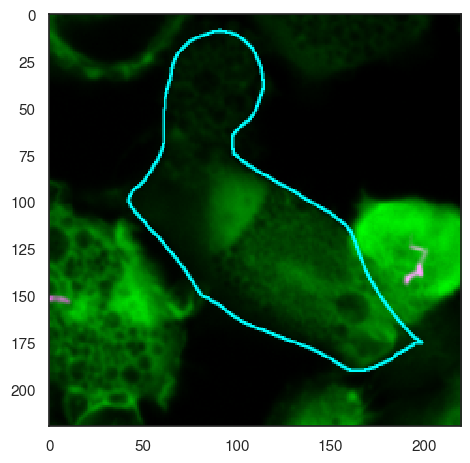

In [551]:
test = tn_glimpse_maker(unique_ID = '433.3.4', df = df, time = 1)
imshow(test)